# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
image_shape = str(X_train.shape[1]) + "x" + str(X_train.shape[2]) + "x" + str(X_train.shape[3])

output = set()
for x in y_train:
    output.add(x)

# TODO: how many classes are in the dataset
n_classes = len(output)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = 32x32x3
Number of classes = 43


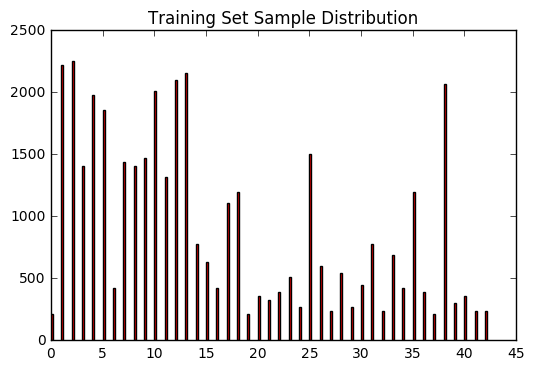

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import csv
import cv2

def findsignnames(filename):
    signnames = []
    with open(filename, 'rt') as csvfile:
        signnamereader = csv.reader(csvfile)
        for row in signnamereader:
            signnames.append(row[1])
    signnames = signnames[1:]
    return signnames

'''For future use , extracting signnames'''
signnames = findsignnames('signnames.csv')
#print(signnames)

#print (X_train.shape)
#print (X_test.shape)
#print (y_train.shape)
#print (y_test.shape)
#print(y_test[0])

class_set = np.zeros(n_classes)
for label in y_train:
    class_set[label] = class_set[label]+1


ind = np.arange(n_classes)
width = 0.2
fig, ax = plt.subplots()
ax.set_title('Training Set Sample Distribution')
rects1 = ax.bar(ind, class_set, width, color='r')

#cv2.imshow("test",X_train[0])
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [15]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import math
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
import cv2
import random
from sklearn.model_selection import train_test_split


training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

#####First apply 1-hot encoding on the output

encoder = LabelBinarizer()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

# Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)


###Helper function section

def converttonormalizedata(images):
    imagescopy = np.copy(images)
    imagescopy = imagescopy.astype(float)
    i = 0
    for image in images:
        normalizedimage = normalize(image)
        np.put(imagescopy,[i],[normalizedimage])
        i+=1
    return imagescopy


def normalize(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    dst = np.empty(image_data.shape)
    normalizedImage = cv2.normalize(image_data, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F, dst=dst)
    return normalizedImage
    

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


##Normalize the data

X_train = converttonormalizedata(X_train)
X_test =  converttonormalizedata(X_test)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.05,
    random_state=832289)

learning_rate = 0.05
training_epochs = 100
batch_size = 100
display_step = 1

n_input = 3072  #  data input (img shape: 32*32*3)
n_classes = 43  # total classes (43)

# input data is of type 32*32*3
x = tf.placeholder("float", [None, 32, 32, 3])

x_flat = tf.reshape(x, [-1,3072])

W = tf.Variable(tf.zeros([3072, 43]))
b = tf.Variable(tf.zeros([43]))
y = tf.matmul(x_flat, W) + b

y_ = tf.placeholder(tf.float32, [None, 43])

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

####Training data, validation data and test data
train_feed_dict = {x: X_train, y_: y_train}
valid_feed_dict = {x: X_valid, y_: y_valid}
test_feed_dict = {x: X_test, y_: y_test}


init = tf.initialize_all_variables()

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(X_train)/batch_size))
    
    for epoch_i in range(training_epochs):
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, training_epochs), unit='batches')
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = X_train[batch_start:batch_start + batch_size]
            batch_labels = y_train[batch_start:batch_start + batch_size]
            train_step.run(feed_dict={x: batch_features, y_: batch_labels})

            if batch_i % batch_size == 0:
                train_accuracy = accuracy.eval(feed_dict=valid_feed_dict)
                print("Epoch %d, training accuracy %g"%(epoch_i, train_accuracy))

    print("test accuracy %g"%accuracy.eval(feed_dict=test_feed_dict))

#This is the corresponding classification output

Epoch  1/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 0, training accuracy 0.103009


Epoch  1/100:  26%|██▌       | 96/373 [00:00<00:10, 26.52batches/s]

Epoch 0, training accuracy 0.36818


Epoch  1/100:  51%|█████     | 189/373 [00:00<00:02, 80.75batches/s]

Epoch 0, training accuracy 0.447731


Epoch  1/100:  78%|███████▊  | 291/373 [00:01<00:00, 167.90batches/s]

Epoch 0, training accuracy 0.441101


Epoch  2/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 1, training accuracy 0.571647


Epoch  2/100:  26%|██▌       | 96/373 [00:00<00:01, 201.13batches/s]

Epoch 1, training accuracy 0.524732


Epoch  2/100:  46%|████▋     | 173/373 [00:00<00:00, 225.87batches/s]

Epoch 1, training accuracy 0.650178


Epoch  2/100:  76%|███████▌  | 283/373 [00:01<00:00, 245.25batches/s]

Epoch 1, training accuracy 0.607343


Epoch  3/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 2, training accuracy 0.700663


Epoch  3/100:  25%|██▌       | 94/373 [00:00<00:01, 198.69batches/s]

Epoch 2, training accuracy 0.624171


Epoch  3/100:  49%|████▊     | 181/373 [00:00<00:00, 204.20batches/s]

Epoch 2, training accuracy 0.707802


Epoch  3/100:  74%|███████▍  | 276/373 [00:01<00:00, 225.82batches/s]

Epoch 2, training accuracy 0.776645


Epoch  4/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 3, training accuracy 0.781234


Epoch  4/100:  18%|█▊        | 68/373 [00:00<00:01, 188.63batches/s]

Epoch 3, training accuracy 0.773585


Epoch  4/100:  50%|█████     | 188/373 [00:00<00:00, 253.20batches/s]

Epoch 3, training accuracy 0.745028


Epoch  4/100:  79%|███████▊  | 293/373 [00:01<00:00, 242.70batches/s]

Epoch 3, training accuracy 0.688934


Epoch  5/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 4, training accuracy 0.789903


Epoch  5/100:  26%|██▌       | 97/373 [00:00<00:01, 203.58batches/s]

Epoch 4, training accuracy 0.72616


Epoch  5/100:  46%|████▌     | 172/373 [00:00<00:00, 231.59batches/s]

Epoch 4, training accuracy 0.812851


Epoch  5/100:  76%|███████▋  | 285/373 [00:01<00:00, 260.02batches/s]

Epoch 4, training accuracy 0.853646


Epoch  6/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 5, training accuracy 0.803162


Epoch  6/100:  20%|██        | 76/373 [00:00<00:01, 212.90batches/s]

Epoch 5, training accuracy 0.787353


Epoch  6/100:  50%|█████     | 187/373 [00:00<00:00, 246.75batches/s]

Epoch 5, training accuracy 0.844977


Epoch  6/100:  77%|███████▋  | 287/373 [00:01<00:00, 229.65batches/s]

Epoch 5, training accuracy 0.828659


Epoch  7/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 6, training accuracy 0.844467


Epoch  7/100:  21%|██        | 77/373 [00:00<00:01, 160.73batches/s]

Epoch 6, training accuracy 0.767976


Epoch  7/100:  47%|████▋     | 174/373 [00:00<00:00, 211.51batches/s]

Epoch 6, training accuracy 0.808261


Epoch  7/100:  77%|███████▋  | 288/373 [00:01<00:00, 253.89batches/s]

Epoch 6, training accuracy 0.81948


Epoch  8/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 7, training accuracy 0.851606


Epoch  8/100:  20%|██        | 75/373 [00:00<00:01, 198.15batches/s]

Epoch 7, training accuracy 0.802142


Epoch  8/100:  51%|█████     | 191/373 [00:00<00:00, 254.93batches/s]

Epoch 7, training accuracy 0.866395


Epoch  8/100:  79%|███████▉  | 294/373 [00:01<00:00, 242.36batches/s]

Epoch 7, training accuracy 0.862315


Epoch  9/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 8, training accuracy 0.831719


Epoch  9/100:  27%|██▋       | 100/373 [00:00<00:01, 137.99batches/s]

Epoch 8, training accuracy 0.787353


Epoch  9/100:  49%|████▉     | 184/373 [00:00<00:01, 183.32batches/s]

Epoch 8, training accuracy 0.886283


Epoch  9/100:  75%|███████▍  | 278/373 [00:01<00:00, 212.07batches/s]

Epoch 8, training accuracy 0.850076


Epoch 10/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 9, training accuracy 0.847017


Epoch 10/100:  21%|██        | 78/373 [00:00<00:01, 228.28batches/s]

Epoch 9, training accuracy 0.845997


Epoch 10/100:  48%|████▊     | 178/373 [00:00<00:00, 236.49batches/s]

Epoch 9, training accuracy 0.872004


Epoch 10/100:  75%|███████▍  | 279/373 [00:01<00:00, 235.98batches/s]

Epoch 9, training accuracy 0.890362


Epoch 11/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 10, training accuracy 0.847017


Epoch 11/100:  23%|██▎       | 87/373 [00:00<00:01, 194.84batches/s]

Epoch 10, training accuracy 0.797042


Epoch 11/100:  51%|█████▏    | 192/373 [00:00<00:00, 241.30batches/s]

Epoch 10, training accuracy 0.898011


Epoch 11/100:  77%|███████▋  | 289/373 [00:01<00:00, 231.21batches/s]

Epoch 10, training accuracy 0.880163


Epoch 12/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 11, training accuracy 0.831209


Epoch 12/100:  27%|██▋       | 99/373 [00:00<00:01, 231.24batches/s]

Epoch 11, training accuracy 0.81387


Epoch 12/100:  53%|█████▎    | 196/373 [00:00<00:00, 229.75batches/s]

Epoch 11, training accuracy 0.904131


Epoch 12/100:  74%|███████▍  | 277/373 [00:01<00:00, 246.17batches/s]

Epoch 11, training accuracy 0.90872


Epoch 13/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 12, training accuracy 0.876084


Epoch 13/100:  25%|██▌       | 95/373 [00:00<00:01, 203.84batches/s]

Epoch 12, training accuracy 0.875064


Epoch 13/100:  50%|█████     | 187/373 [00:00<00:00, 206.85batches/s]

Epoch 12, training accuracy 0.91025


Epoch 13/100:  75%|███████▌  | 281/373 [00:01<00:00, 222.84batches/s]

Epoch 12, training accuracy 0.875064


Epoch 14/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 13, training accuracy 0.892912


Epoch 14/100:  25%|██▍       | 93/373 [00:00<00:01, 198.84batches/s]

Epoch 13, training accuracy 0.875064


Epoch 14/100:  51%|█████     | 191/373 [00:00<00:00, 227.11batches/s]

Epoch 13, training accuracy 0.856706


Epoch 14/100:  77%|███████▋  | 287/373 [00:01<00:00, 221.05batches/s]

Epoch 13, training accuracy 0.917899


Epoch 15/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 14, training accuracy 0.880163


Epoch 15/100:  24%|██▍       | 91/373 [00:00<00:01, 200.58batches/s]

Epoch 14, training accuracy 0.861805


Epoch 15/100:  54%|█████▎    | 200/373 [00:00<00:00, 210.69batches/s]

Epoch 14, training accuracy 0.898011


Epoch 15/100:  77%|███████▋  | 287/373 [00:01<00:00, 206.03batches/s]

Epoch 14, training accuracy 0.90617


Epoch 16/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 15, training accuracy 0.854156


Epoch 16/100:  24%|██▎       | 88/373 [00:00<00:01, 189.66batches/s]

Epoch 15, training accuracy 0.889342


Epoch 16/100:  50%|█████     | 187/373 [00:00<00:00, 231.60batches/s]

Epoch 15, training accuracy 0.882713


Epoch 16/100:  78%|███████▊  | 290/373 [00:01<00:00, 244.80batches/s]

Epoch 15, training accuracy 0.877104


Epoch 17/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 16, training accuracy 0.863335


Epoch 17/100:  25%|██▌       | 94/373 [00:00<00:01, 209.06batches/s]

Epoch 16, training accuracy 0.878633


Epoch 17/100:  50%|█████     | 188/373 [00:00<00:00, 226.09batches/s]

Epoch 16, training accuracy 0.893932


Epoch 17/100:  76%|███████▌  | 284/373 [00:01<00:00, 228.45batches/s]

Epoch 16, training accuracy 0.91127


Epoch 18/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 17, training accuracy 0.810301


Epoch 18/100:  20%|█▉        | 73/373 [00:00<00:01, 202.24batches/s]

Epoch 17, training accuracy 0.861805


Epoch 18/100:  50%|████▉     | 185/373 [00:00<00:00, 243.12batches/s]

Epoch 17, training accuracy 0.867925


Epoch 18/100:  80%|████████  | 300/373 [00:01<00:00, 208.01batches/s]

Epoch 17, training accuracy 0.91178


Epoch 19/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 18, training accuracy 0.886792


Epoch 19/100:  21%|██        | 77/373 [00:00<00:02, 146.57batches/s]

Epoch 18, training accuracy 0.896991


Epoch 19/100:  49%|████▉     | 184/373 [00:00<00:00, 190.35batches/s]

Epoch 18, training accuracy 0.924528


Epoch 19/100:  75%|███████▍  | 279/373 [00:01<00:00, 220.37batches/s]

Epoch 18, training accuracy 0.877613


Epoch 20/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 19, training accuracy 0.90566


Epoch 20/100:  23%|██▎       | 86/373 [00:00<00:01, 172.80batches/s]

Epoch 19, training accuracy 0.855686


Epoch 20/100:  51%|█████     | 189/373 [00:00<00:00, 194.71batches/s]

Epoch 19, training accuracy 0.917899


Epoch 20/100:  77%|███████▋  | 287/373 [00:01<00:00, 224.03batches/s]

Epoch 19, training accuracy 0.916369


Epoch 21/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 20, training accuracy 0.899031


Epoch 21/100:  20%|█▉        | 74/373 [00:00<00:01, 221.02batches/s]

Epoch 20, training accuracy 0.863335


Epoch 21/100:  51%|█████     | 189/373 [00:00<00:00, 216.45batches/s]

Epoch 20, training accuracy 0.874044


Epoch 21/100:  78%|███████▊  | 291/373 [00:01<00:00, 234.91batches/s]

Epoch 20, training accuracy 0.903621


Epoch 22/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 21, training accuracy 0.90617


Epoch 22/100:  25%|██▍       | 92/373 [00:00<00:01, 185.54batches/s]

Epoch 21, training accuracy 0.90974


Epoch 22/100:  48%|████▊     | 180/373 [00:00<00:00, 208.69batches/s]

Epoch 21, training accuracy 0.91331


Epoch 22/100:  75%|███████▌  | 280/373 [00:01<00:00, 230.35batches/s]

Epoch 21, training accuracy 0.91229


Epoch 23/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 22, training accuracy 0.897501


Epoch 23/100:  24%|██▎       | 88/373 [00:00<00:01, 192.12batches/s]

Epoch 22, training accuracy 0.884753


Epoch 23/100:  53%|█████▎    | 199/373 [00:00<00:00, 214.68batches/s]

Epoch 22, training accuracy 0.91025


Epoch 23/100:  79%|███████▉  | 295/373 [00:01<00:00, 216.69batches/s]

Epoch 22, training accuracy 0.922489


Epoch 24/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 23, training accuracy 0.893422


Epoch 24/100:  24%|██▍       | 91/373 [00:00<00:01, 195.85batches/s]

Epoch 23, training accuracy 0.886792


Epoch 24/100:  48%|████▊     | 180/373 [00:00<00:00, 209.53batches/s]

Epoch 23, training accuracy 0.922489


Epoch 24/100:  77%|███████▋  | 286/373 [00:01<00:00, 246.60batches/s]

Epoch 23, training accuracy 0.91025


Epoch 25/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 24, training accuracy 0.866395


Epoch 25/100:  24%|██▍       | 91/373 [00:00<00:01, 165.68batches/s]

Epoch 24, training accuracy 0.873024


Epoch 25/100:  52%|█████▏    | 195/373 [00:01<00:00, 199.04batches/s]

Epoch 24, training accuracy 0.90566


Epoch 25/100:  77%|███████▋  | 288/373 [00:01<00:00, 215.47batches/s]

Epoch 24, training accuracy 0.919939


Epoch 26/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 25, training accuracy 0.899541


Epoch 26/100:  23%|██▎       | 86/373 [00:00<00:02, 134.41batches/s]

Epoch 25, training accuracy 0.888322


Epoch 26/100:  49%|████▉     | 182/373 [00:01<00:01, 177.70batches/s]

Epoch 25, training accuracy 0.898521


Epoch 26/100:  79%|███████▊  | 293/373 [00:01<00:00, 207.72batches/s]

Epoch 25, training accuracy 0.919429


Epoch 27/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 26, training accuracy 0.892402


Epoch 27/100:  21%|██        | 78/373 [00:00<00:01, 173.17batches/s]

Epoch 26, training accuracy 0.864355


Epoch 27/100:  49%|████▉     | 184/373 [00:00<00:00, 226.98batches/s]

Epoch 26, training accuracy 0.925548


Epoch 27/100:  77%|███████▋  | 288/373 [00:01<00:00, 220.67batches/s]

Epoch 26, training accuracy 0.90668


Epoch 28/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 27, training accuracy 0.895461


Epoch 28/100:  24%|██▍       | 89/373 [00:00<00:01, 196.59batches/s]

Epoch 27, training accuracy 0.904131


Epoch 28/100:  50%|████▉     | 186/373 [00:00<00:00, 227.06batches/s]

Epoch 27, training accuracy 0.90668


Epoch 28/100:  76%|███████▌  | 282/373 [00:01<00:00, 229.98batches/s]

Epoch 27, training accuracy 0.918919


Epoch 29/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 28, training accuracy 0.91229


Epoch 29/100:  24%|██▍       | 90/373 [00:00<00:01, 195.70batches/s]

Epoch 28, training accuracy 0.828659


Epoch 29/100:  49%|████▊     | 181/373 [00:00<00:00, 207.70batches/s]

Epoch 28, training accuracy 0.904131


Epoch 29/100:  80%|████████  | 300/373 [00:01<00:00, 228.55batches/s]

Epoch 28, training accuracy 0.915859


Epoch 30/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 29, training accuracy 0.896991


Epoch 30/100:  23%|██▎       | 86/373 [00:00<00:01, 182.05batches/s]

Epoch 29, training accuracy 0.90719


Epoch 30/100:  48%|████▊     | 178/373 [00:00<00:00, 217.21batches/s]

Epoch 29, training accuracy 0.900561


Epoch 30/100:  75%|███████▍  | 278/373 [00:01<00:00, 232.86batches/s]

Epoch 29, training accuracy 0.901581


Epoch 31/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 30, training accuracy 0.893932


Epoch 31/100:  22%|██▏       | 82/373 [00:00<00:01, 184.95batches/s]

Epoch 30, training accuracy 0.880163


Epoch 31/100:  48%|████▊     | 179/373 [00:00<00:00, 223.88batches/s]

Epoch 30, training accuracy 0.919939


Epoch 31/100:  78%|███████▊  | 291/373 [00:01<00:00, 210.17batches/s]

Epoch 30, training accuracy 0.929118


Epoch 32/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 31, training accuracy 0.873534


Epoch 32/100:  23%|██▎       | 85/373 [00:00<00:01, 181.12batches/s]

Epoch 31, training accuracy 0.921979


Epoch 32/100:  53%|█████▎    | 199/373 [00:00<00:00, 211.58batches/s]

Epoch 31, training accuracy 0.932687


Epoch 32/100:  78%|███████▊  | 291/373 [00:01<00:00, 214.50batches/s]

Epoch 31, training accuracy 0.884243


Epoch 33/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 32, training accuracy 0.881693


Epoch 33/100:  21%|██        | 79/373 [00:00<00:01, 179.45batches/s]

Epoch 32, training accuracy 0.90515


Epoch 33/100:  53%|█████▎    | 196/373 [00:00<00:00, 208.72batches/s]

Epoch 32, training accuracy 0.925548


Epoch 33/100:  77%|███████▋  | 289/373 [00:01<00:00, 212.93batches/s]

Epoch 32, training accuracy 0.914839


Epoch 34/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 33, training accuracy 0.930648


Epoch 34/100:  24%|██▍       | 91/373 [00:00<00:01, 195.55batches/s]

Epoch 33, training accuracy 0.90872


Epoch 34/100:  53%|█████▎    | 199/373 [00:00<00:00, 208.71batches/s]

Epoch 33, training accuracy 0.929628


Epoch 34/100:  77%|███████▋  | 286/373 [00:01<00:00, 204.31batches/s]

Epoch 33, training accuracy 0.926058


Epoch 35/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 34, training accuracy 0.91331


Epoch 35/100:  23%|██▎       | 85/373 [00:00<00:01, 182.17batches/s]

Epoch 34, training accuracy 0.927588


Epoch 35/100:  53%|█████▎    | 199/373 [00:00<00:00, 221.18batches/s]

Epoch 34, training accuracy 0.925548


Epoch 35/100:  79%|███████▉  | 295/373 [00:01<00:00, 215.64batches/s]

Epoch 34, training accuracy 0.939827


Epoch 36/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 35, training accuracy 0.90566


Epoch 36/100:  21%|██        | 79/373 [00:00<00:02, 146.44batches/s]

Epoch 35, training accuracy 0.902091


Epoch 36/100:  49%|████▉     | 182/373 [00:00<00:00, 211.21batches/s]

Epoch 35, training accuracy 0.933707


Epoch 36/100:  77%|███████▋  | 288/373 [00:01<00:00, 240.59batches/s]

Epoch 35, training accuracy 0.926568


Epoch 37/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 36, training accuracy 0.917899


Epoch 37/100:  21%|██▏       | 80/373 [00:00<00:01, 170.39batches/s]

Epoch 36, training accuracy 0.913819


Epoch 37/100:  51%|█████     | 191/373 [00:00<00:00, 206.41batches/s]

Epoch 36, training accuracy 0.900561


Epoch 37/100:  76%|███████▌  | 283/373 [00:01<00:00, 215.58batches/s]

Epoch 36, training accuracy 0.914329


Epoch 38/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 37, training accuracy 0.920959


Epoch 38/100:  23%|██▎       | 86/373 [00:00<00:01, 187.92batches/s]

Epoch 37, training accuracy 0.91025


Epoch 38/100:  51%|█████     | 190/373 [00:00<00:00, 209.03batches/s]

Epoch 37, training accuracy 0.929118


Epoch 38/100:  79%|███████▊  | 293/373 [00:01<00:00, 234.56batches/s]

Epoch 37, training accuracy 0.884753


Epoch 39/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 38, training accuracy 0.915859


Epoch 39/100:  25%|██▍       | 92/373 [00:00<00:01, 207.21batches/s]

Epoch 38, training accuracy 0.796022


Epoch 39/100:  49%|████▉     | 184/373 [00:00<00:00, 209.61batches/s]

Epoch 38, training accuracy 0.942376


Epoch 39/100:  79%|███████▉  | 296/373 [00:01<00:00, 209.75batches/s]

Epoch 38, training accuracy 0.893422


Epoch 40/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 39, training accuracy 0.921979


Epoch 40/100:  27%|██▋       | 100/373 [00:00<00:01, 186.50batches/s]

Epoch 39, training accuracy 0.923508


Epoch 40/100:  52%|█████▏    | 193/373 [00:00<00:00, 211.13batches/s]

Epoch 39, training accuracy 0.927078


Epoch 40/100:  77%|███████▋  | 287/373 [00:01<00:00, 219.61batches/s]

Epoch 39, training accuracy 0.931668


Epoch 41/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 40, training accuracy 0.91127


Epoch 41/100:  24%|██▎       | 88/373 [00:00<00:01, 190.07batches/s]

Epoch 40, training accuracy 0.917389


Epoch 41/100:  48%|████▊     | 180/373 [00:00<00:00, 217.31batches/s]

Epoch 40, training accuracy 0.931158


Epoch 41/100:  75%|███████▍  | 278/373 [00:01<00:00, 234.94batches/s]

Epoch 40, training accuracy 0.915859


Epoch 42/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 41, training accuracy 0.880673


Epoch 42/100:  24%|██▍       | 89/373 [00:00<00:01, 189.71batches/s]

Epoch 41, training accuracy 0.91178


Epoch 42/100:  52%|█████▏    | 194/373 [00:00<00:00, 202.86batches/s]

Epoch 41, training accuracy 0.921469


Epoch 42/100:  76%|███████▌  | 284/373 [00:01<00:00, 208.32batches/s]

Epoch 41, training accuracy 0.919429


Epoch 43/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 42, training accuracy 0.90464


Epoch 43/100:  21%|██        | 78/373 [00:00<00:01, 155.76batches/s]

Epoch 42, training accuracy 0.849567


Epoch 43/100:  50%|████▉     | 185/373 [00:00<00:00, 192.82batches/s]

Epoch 42, training accuracy 0.926058


Epoch 43/100:  78%|███████▊  | 292/373 [00:01<00:00, 192.20batches/s]

Epoch 42, training accuracy 0.929118


Epoch 44/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 43, training accuracy 0.917389


Epoch 44/100:  25%|██▌       | 95/373 [00:00<00:01, 165.50batches/s]

Epoch 43, training accuracy 0.827129


Epoch 44/100:  48%|████▊     | 180/373 [00:00<00:00, 194.03batches/s]

Epoch 43, training accuracy 0.920449


Epoch 44/100:  79%|███████▉  | 295/373 [00:01<00:00, 222.36batches/s]

Epoch 43, training accuracy 0.934727


Epoch 45/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 44, training accuracy 0.936767


Epoch 45/100:  26%|██▌       | 96/373 [00:00<00:01, 168.37batches/s]

Epoch 44, training accuracy 0.928098


Epoch 45/100:  48%|████▊     | 180/373 [00:00<00:00, 197.52batches/s]

Epoch 44, training accuracy 0.933197


Epoch 45/100:  80%|███████▉  | 297/373 [00:01<00:00, 222.54batches/s]

Epoch 44, training accuracy 0.937787


Epoch 46/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 45, training accuracy 0.922489


Epoch 46/100:  21%|██        | 78/373 [00:00<00:01, 173.95batches/s]

Epoch 45, training accuracy 0.90566


Epoch 46/100:  50%|████▉     | 185/373 [00:00<00:00, 193.41batches/s]

Epoch 45, training accuracy 0.936257


Epoch 46/100:  74%|███████▍  | 277/373 [00:01<00:00, 207.89batches/s]

Epoch 45, training accuracy 0.925548


Epoch 47/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 46, training accuracy 0.91331


Epoch 47/100:  24%|██▍       | 90/373 [00:00<00:01, 196.23batches/s]

Epoch 46, training accuracy 0.931668


Epoch 47/100:  49%|████▉     | 184/373 [00:00<00:00, 222.18batches/s]

Epoch 46, training accuracy 0.926568


Epoch 47/100:  77%|███████▋  | 288/373 [00:01<00:00, 243.51batches/s]

Epoch 46, training accuracy 0.925548


Epoch 48/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 47, training accuracy 0.877104


Epoch 48/100:  25%|██▌       | 94/373 [00:00<00:01, 211.60batches/s]

Epoch 47, training accuracy 0.90617


Epoch 48/100:  53%|█████▎    | 198/373 [00:00<00:00, 200.46batches/s]

Epoch 47, training accuracy 0.935747


Epoch 48/100:  80%|███████▉  | 298/373 [00:01<00:00, 233.63batches/s]

Epoch 47, training accuracy 0.934217


Epoch 49/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 48, training accuracy 0.921979


Epoch 49/100:  27%|██▋       | 99/373 [00:00<00:01, 226.53batches/s]

Epoch 48, training accuracy 0.880163


Epoch 49/100:  51%|█████     | 191/373 [00:00<00:00, 222.53batches/s]

Epoch 48, training accuracy 0.940337


Epoch 49/100:  78%|███████▊  | 292/373 [00:01<00:00, 237.18batches/s]

Epoch 48, training accuracy 0.934217


Epoch 50/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 49, training accuracy 0.925038


Epoch 50/100:  26%|██▌       | 97/373 [00:00<00:01, 214.26batches/s]

Epoch 49, training accuracy 0.899541


Epoch 50/100:  54%|█████▎    | 200/373 [00:00<00:00, 241.21batches/s]

Epoch 49, training accuracy 0.939317


Epoch 50/100:  76%|███████▌  | 282/373 [00:01<00:00, 247.73batches/s]

Epoch 49, training accuracy 0.90719


Epoch 51/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 50, training accuracy 0.930138


Epoch 51/100:  27%|██▋       | 100/373 [00:00<00:01, 222.21batches/s]

Epoch 50, training accuracy 0.932687


Epoch 51/100:  47%|████▋     | 176/373 [00:00<00:00, 234.16batches/s]

Epoch 50, training accuracy 0.939827


Epoch 51/100:  74%|███████▍  | 277/373 [00:01<00:00, 240.98batches/s]

Epoch 50, training accuracy 0.923508


Epoch 52/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 51, training accuracy 0.90872


Epoch 52/100:  25%|██▍       | 93/373 [00:00<00:01, 211.05batches/s]

Epoch 51, training accuracy 0.934727


Epoch 52/100:  48%|████▊     | 180/373 [00:00<00:00, 209.42batches/s]

Epoch 51, training accuracy 0.931158


Epoch 52/100:  80%|████████  | 300/373 [00:01<00:00, 191.36batches/s]

Epoch 51, training accuracy 0.90464


Epoch 53/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 52, training accuracy 0.90617


Epoch 53/100:  24%|██▍       | 89/373 [00:00<00:01, 147.51batches/s]

Epoch 52, training accuracy 0.935237


Epoch 53/100:  53%|█████▎    | 196/373 [00:01<00:01, 173.30batches/s]

Epoch 52, training accuracy 0.921979


Epoch 53/100:  75%|███████▌  | 281/373 [00:01<00:00, 192.91batches/s]

Epoch 52, training accuracy 0.933197


Epoch 54/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 53, training accuracy 0.913819


Epoch 54/100:  23%|██▎       | 86/373 [00:00<00:01, 178.06batches/s]

Epoch 53, training accuracy 0.941356


Epoch 54/100:  49%|████▊     | 181/373 [00:00<00:01, 184.49batches/s]

Epoch 53, training accuracy 0.931158


Epoch 54/100:  76%|███████▌  | 282/373 [00:01<00:00, 193.97batches/s]

Epoch 53, training accuracy 0.935237


Epoch 55/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 54, training accuracy 0.916369


Epoch 55/100:  25%|██▌       | 95/373 [00:00<00:01, 170.99batches/s]

Epoch 54, training accuracy 0.904131


Epoch 55/100:  51%|█████▏    | 192/373 [00:01<00:00, 183.02batches/s]

Epoch 54, training accuracy 0.934217


Epoch 55/100:  75%|███████▍  | 278/373 [00:01<00:00, 193.09batches/s]

Epoch 54, training accuracy 0.934727


Epoch 56/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 55, training accuracy 0.925548


Epoch 56/100:  25%|██▍       | 93/373 [00:00<00:01, 157.53batches/s]

Epoch 55, training accuracy 0.858236


Epoch 56/100:  53%|█████▎    | 198/373 [00:01<00:00, 195.88batches/s]

Epoch 55, training accuracy 0.935747


Epoch 56/100:  76%|███████▋  | 285/373 [00:01<00:00, 198.29batches/s]

Epoch 55, training accuracy 0.924018


Epoch 57/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 56, training accuracy 0.927588


Epoch 57/100:  25%|██▌       | 94/373 [00:00<00:01, 179.62batches/s]

Epoch 56, training accuracy 0.927078


Epoch 57/100:  52%|█████▏    | 195/373 [00:01<00:00, 189.87batches/s]

Epoch 56, training accuracy 0.933707


Epoch 57/100:  75%|███████▌  | 280/373 [00:01<00:00, 196.02batches/s]

Epoch 56, training accuracy 0.926568


Epoch 58/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 57, training accuracy 0.90821


Epoch 58/100:  22%|██▏       | 81/373 [00:00<00:01, 165.19batches/s]

Epoch 57, training accuracy 0.929118


Epoch 58/100:  54%|█████▎    | 200/373 [00:01<00:01, 172.65batches/s]

Epoch 57, training accuracy 0.936257


Epoch 58/100:  76%|███████▌  | 284/373 [00:01<00:00, 157.68batches/s]

Epoch 57, training accuracy 0.936257


Epoch 59/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 58, training accuracy 0.902601


Epoch 59/100:  23%|██▎       | 85/373 [00:00<00:01, 158.99batches/s]

Epoch 58, training accuracy 0.938807


Epoch 59/100:  48%|████▊     | 179/373 [00:01<00:01, 177.00batches/s]

Epoch 58, training accuracy 0.943906


Epoch 59/100:  79%|███████▉  | 296/373 [00:01<00:00, 216.39batches/s]

Epoch 58, training accuracy 0.941866


Epoch 60/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 59, training accuracy 0.927588


Epoch 60/100:  27%|██▋       | 100/373 [00:00<00:01, 179.49batches/s]

Epoch 59, training accuracy 0.842427


Epoch 60/100:  49%|████▊     | 181/373 [00:00<00:01, 181.96batches/s]

Epoch 59, training accuracy 0.932177


Epoch 60/100:  73%|███████▎  | 274/373 [00:01<00:00, 212.22batches/s]

Epoch 59, training accuracy 0.919429


Epoch 61/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 60, training accuracy 0.929118


Epoch 61/100:  24%|██▍       | 91/373 [00:00<00:01, 160.39batches/s]

Epoch 60, training accuracy 0.924528


Epoch 61/100:  50%|█████     | 188/373 [00:01<00:00, 185.92batches/s]

Epoch 60, training accuracy 0.925038


Epoch 61/100:  76%|███████▌  | 283/373 [00:01<00:00, 179.29batches/s]

Epoch 60, training accuracy 0.932687


Epoch 62/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 61, training accuracy 0.91127


Epoch 62/100:  22%|██▏       | 81/373 [00:00<00:01, 173.75batches/s]

Epoch 61, training accuracy 0.922998


Epoch 62/100:  54%|█████▎    | 200/373 [00:00<00:00, 223.43batches/s]

Epoch 61, training accuracy 0.891382


Epoch 62/100:  79%|███████▉  | 294/373 [00:01<00:00, 218.60batches/s]

Epoch 61, training accuracy 0.936257


Epoch 63/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 62, training accuracy 0.927078


Epoch 63/100:  22%|██▏       | 81/373 [00:00<00:01, 170.47batches/s]

Epoch 62, training accuracy 0.930648


Epoch 63/100:  48%|████▊     | 178/373 [00:00<00:00, 218.21batches/s]

Epoch 62, training accuracy 0.924528


Epoch 63/100:  76%|███████▌  | 284/373 [00:01<00:00, 248.65batches/s]

Epoch 62, training accuracy 0.930138


Epoch 64/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 63, training accuracy 0.891382


Epoch 64/100:  26%|██▌       | 96/373 [00:00<00:01, 199.78batches/s]

Epoch 63, training accuracy 0.91076


Epoch 64/100:  53%|█████▎    | 197/373 [00:00<00:00, 231.83batches/s]

Epoch 63, training accuracy 0.919939


Epoch 64/100:  80%|███████▉  | 298/373 [00:01<00:00, 238.61batches/s]

Epoch 63, training accuracy 0.933197


Epoch 65/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 64, training accuracy 0.914329


Epoch 65/100:  25%|██▌       | 95/373 [00:00<00:01, 195.20batches/s]

Epoch 64, training accuracy 0.811831


Epoch 65/100:  50%|█████     | 187/373 [00:00<00:00, 217.43batches/s]

Epoch 64, training accuracy 0.930138


Epoch 65/100:  78%|███████▊  | 290/373 [00:01<00:00, 238.71batches/s]

Epoch 64, training accuracy 0.937277


Epoch 66/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 65, training accuracy 0.937277


Epoch 66/100:  20%|██        | 76/373 [00:00<00:01, 212.27batches/s]

Epoch 65, training accuracy 0.927078


Epoch 66/100:  50%|████▉     | 186/373 [00:00<00:00, 251.00batches/s]

Epoch 65, training accuracy 0.947476


Epoch 66/100:  79%|███████▉  | 295/373 [00:01<00:00, 258.33batches/s]

Epoch 65, training accuracy 0.945436


Epoch 67/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 66, training accuracy 0.917389


Epoch 67/100:  20%|█▉        | 73/373 [00:00<00:01, 209.39batches/s]

Epoch 66, training accuracy 0.938807


Epoch 67/100:  50%|████▉     | 186/373 [00:00<00:00, 251.80batches/s]

Epoch 66, training accuracy 0.933707


Epoch 67/100:  79%|███████▉  | 295/373 [00:01<00:00, 258.50batches/s]

Epoch 66, training accuracy 0.929628


Epoch 68/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 67, training accuracy 0.90923


Epoch 68/100:  20%|██        | 75/373 [00:00<00:01, 224.67batches/s]

Epoch 67, training accuracy 0.873024


Epoch 68/100:  48%|████▊     | 179/373 [00:00<00:00, 242.69batches/s]

Epoch 67, training accuracy 0.938297


Epoch 68/100:  76%|███████▌  | 284/373 [00:01<00:00, 251.30batches/s]

Epoch 67, training accuracy 0.935747


Epoch 69/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 68, training accuracy 0.932687


Epoch 69/100:  27%|██▋       | 99/373 [00:00<00:01, 219.14batches/s]

Epoch 68, training accuracy 0.91076


Epoch 69/100:  54%|█████▎    | 200/373 [00:00<00:00, 241.00batches/s]

Epoch 68, training accuracy 0.938297


Epoch 69/100:  75%|███████▌  | 280/373 [00:01<00:00, 246.99batches/s]

Epoch 68, training accuracy 0.937787


Epoch 70/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 69, training accuracy 0.928098


Epoch 70/100:  21%|██        | 78/373 [00:00<00:01, 227.79batches/s]

Epoch 69, training accuracy 0.835288


Epoch 70/100:  49%|████▉     | 182/373 [00:00<00:00, 248.88batches/s]

Epoch 69, training accuracy 0.941866


Epoch 70/100:  78%|███████▊  | 292/373 [00:01<00:00, 261.09batches/s]

Epoch 69, training accuracy 0.925038


Epoch 71/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 70, training accuracy 0.915349


Epoch 71/100:  20%|█▉        | 73/373 [00:00<00:01, 204.01batches/s]

Epoch 70, training accuracy 0.937787


Epoch 71/100:  50%|████▉     | 186/373 [00:00<00:00, 248.15batches/s]

Epoch 70, training accuracy 0.929628


Epoch 71/100:  79%|███████▉  | 294/373 [00:01<00:00, 255.97batches/s]

Epoch 70, training accuracy 0.941866


Epoch 72/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 71, training accuracy 0.884243


Epoch 72/100:  27%|██▋       | 99/373 [00:00<00:01, 221.91batches/s]

Epoch 71, training accuracy 0.931158


Epoch 72/100:  46%|████▋     | 173/373 [00:00<00:00, 233.40batches/s]

Epoch 71, training accuracy 0.941356


Epoch 72/100:  76%|███████▌  | 284/373 [00:01<00:00, 253.16batches/s]

Epoch 71, training accuracy 0.924018


Epoch 73/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 72, training accuracy 0.927588


Epoch 73/100:  26%|██▌       | 97/373 [00:00<00:01, 210.11batches/s]

Epoch 72, training accuracy 0.927588


Epoch 73/100:  51%|█████     | 191/373 [00:00<00:00, 217.22batches/s]

Epoch 72, training accuracy 0.938807


Epoch 73/100:  78%|███████▊  | 291/373 [00:01<00:00, 233.40batches/s]

Epoch 72, training accuracy 0.940847


Epoch 74/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 73, training accuracy 0.925548


Epoch 74/100:  25%|██▌       | 95/373 [00:00<00:01, 213.91batches/s]

Epoch 73, training accuracy 0.932177


Epoch 74/100:  52%|█████▏    | 193/373 [00:00<00:00, 234.86batches/s]

Epoch 73, training accuracy 0.933707


Epoch 74/100:  79%|███████▉  | 295/373 [00:01<00:00, 240.57batches/s]

Epoch 73, training accuracy 0.934727


Epoch 75/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 74, training accuracy 0.918919


Epoch 75/100:  24%|██▍       | 91/373 [00:00<00:01, 206.93batches/s]

Epoch 74, training accuracy 0.81846


Epoch 75/100:  50%|█████     | 188/373 [00:00<00:00, 232.15batches/s]

Epoch 74, training accuracy 0.941866


Epoch 75/100:  79%|███████▉  | 294/373 [00:01<00:00, 248.22batches/s]

Epoch 74, training accuracy 0.925548


Epoch 76/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 75, training accuracy 0.925038


Epoch 76/100:  26%|██▌       | 96/373 [00:00<00:01, 213.41batches/s]

Epoch 75, training accuracy 0.921469


Epoch 76/100:  53%|█████▎    | 196/373 [00:00<00:00, 240.10batches/s]

Epoch 75, training accuracy 0.942886


Epoch 76/100:  80%|████████  | 300/373 [00:01<00:00, 246.79batches/s]

Epoch 75, training accuracy 0.943906


Epoch 77/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 76, training accuracy 0.930138


Epoch 77/100:  26%|██▌       | 97/373 [00:00<00:01, 216.80batches/s]

Epoch 76, training accuracy 0.940847


Epoch 77/100:  46%|████▋     | 173/373 [00:00<00:00, 233.10batches/s]

Epoch 76, training accuracy 0.928608


Epoch 77/100:  80%|████████  | 299/373 [00:01<00:00, 221.35batches/s]

Epoch 76, training accuracy 0.938807


Epoch 78/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 77, training accuracy 0.921469


Epoch 78/100:  21%|██        | 77/373 [00:00<00:01, 178.60batches/s]

Epoch 77, training accuracy 0.932177


Epoch 78/100:  48%|████▊     | 180/373 [00:00<00:00, 225.47batches/s]

Epoch 77, training accuracy 0.943396


Epoch 78/100:  80%|███████▉  | 297/373 [00:01<00:00, 206.00batches/s]

Epoch 77, training accuracy 0.91076


Epoch 79/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 78, training accuracy 0.941866


Epoch 79/100:  24%|██▎       | 88/373 [00:00<00:01, 189.77batches/s]

Epoch 78, training accuracy 0.917899


Epoch 79/100:  53%|█████▎    | 198/373 [00:01<00:00, 181.81batches/s]

Epoch 78, training accuracy 0.939827


Epoch 79/100:  79%|███████▉  | 296/373 [00:01<00:00, 180.96batches/s]

Epoch 78, training accuracy 0.917389


Epoch 80/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 79, training accuracy 0.932177


Epoch 80/100:  27%|██▋       | 99/373 [00:00<00:02, 126.75batches/s]

Epoch 79, training accuracy 0.922489


Epoch 80/100:  50%|████▉     | 185/373 [00:01<00:01, 179.24batches/s]

Epoch 79, training accuracy 0.925548


Epoch 80/100:  76%|███████▌  | 282/373 [00:01<00:00, 175.05batches/s]

Epoch 79, training accuracy 0.937787


Epoch 81/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 80, training accuracy 0.917389


Epoch 81/100:  24%|██▍       | 89/373 [00:00<00:01, 162.58batches/s]

Epoch 80, training accuracy 0.934217


Epoch 81/100:  49%|████▉     | 183/373 [00:01<00:01, 176.68batches/s]

Epoch 80, training accuracy 0.938807


Epoch 81/100:  76%|███████▌  | 282/373 [00:01<00:00, 183.47batches/s]

Epoch 80, training accuracy 0.924018


Epoch 82/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 81, training accuracy 0.940337


Epoch 82/100:  25%|██▌       | 95/373 [00:00<00:01, 156.29batches/s]

Epoch 81, training accuracy 0.897501


Epoch 82/100:  49%|████▉     | 184/373 [00:00<00:00, 194.10batches/s]

Epoch 81, training accuracy 0.938297


Epoch 82/100:  75%|███████▌  | 280/373 [00:01<00:00, 224.95batches/s]

Epoch 81, training accuracy 0.925548


Epoch 83/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 82, training accuracy 0.937787


Epoch 83/100:  23%|██▎       | 87/373 [00:00<00:01, 193.59batches/s]

Epoch 82, training accuracy 0.935237


Epoch 83/100:  51%|█████     | 189/373 [00:00<00:01, 181.65batches/s]

Epoch 82, training accuracy 0.943396


Epoch 83/100:  78%|███████▊  | 290/373 [00:01<00:00, 183.85batches/s]

Epoch 82, training accuracy 0.929628


Epoch 84/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 83, training accuracy 0.932177


Epoch 84/100:  25%|██▌       | 94/373 [00:00<00:01, 176.92batches/s]

Epoch 83, training accuracy 0.934727


Epoch 84/100:  49%|████▉     | 184/373 [00:00<00:00, 202.99batches/s]

Epoch 83, training accuracy 0.926058


Epoch 84/100:  75%|███████▌  | 280/373 [00:01<00:00, 219.96batches/s]

Epoch 83, training accuracy 0.930648


Epoch 85/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 84, training accuracy 0.929628


Epoch 85/100:  25%|██▌       | 94/373 [00:00<00:01, 172.63batches/s]

Epoch 84, training accuracy 0.936257


Epoch 85/100:  53%|█████▎    | 198/373 [00:01<00:00, 183.49batches/s]

Epoch 84, training accuracy 0.934727


Epoch 85/100:  77%|███████▋  | 288/373 [00:01<00:00, 159.85batches/s]

Epoch 84, training accuracy 0.939317


Epoch 86/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 85, training accuracy 0.918409


Epoch 86/100:  23%|██▎       | 85/373 [00:00<00:01, 149.17batches/s]

Epoch 85, training accuracy 0.90821


Epoch 86/100:  51%|█████     | 189/373 [00:01<00:01, 163.81batches/s]

Epoch 85, training accuracy 0.941356


Epoch 86/100:  76%|███████▌  | 284/373 [00:01<00:00, 185.48batches/s]

Epoch 85, training accuracy 0.944416


Epoch 87/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 86, training accuracy 0.929628


Epoch 87/100:  24%|██▍       | 89/373 [00:00<00:01, 190.95batches/s]

Epoch 86, training accuracy 0.918919


Epoch 87/100:  53%|█████▎    | 199/373 [00:01<00:00, 175.62batches/s]

Epoch 86, training accuracy 0.929118


Epoch 87/100:  74%|███████▍  | 277/373 [00:01<00:00, 180.69batches/s]

Epoch 86, training accuracy 0.933707


Epoch 88/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 87, training accuracy 0.881693


Epoch 88/100:  26%|██▌       | 96/373 [00:00<00:01, 172.80batches/s]

Epoch 87, training accuracy 0.930648


Epoch 88/100:  51%|█████     | 189/373 [00:00<00:00, 214.59batches/s]

Epoch 87, training accuracy 0.937277


Epoch 88/100:  77%|███████▋  | 287/373 [00:01<00:00, 227.17batches/s]

Epoch 87, training accuracy 0.935747


Epoch 89/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 88, training accuracy 0.924528


Epoch 89/100:  26%|██▌       | 96/373 [00:00<00:01, 164.80batches/s]

Epoch 88, training accuracy 0.932177


Epoch 89/100:  53%|█████▎    | 199/373 [00:01<00:00, 194.29batches/s]

Epoch 88, training accuracy 0.936767


Epoch 89/100:  77%|███████▋  | 287/373 [00:01<00:00, 201.05batches/s]

Epoch 88, training accuracy 0.931668


Epoch 90/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 89, training accuracy 0.939317


Epoch 90/100:  23%|██▎       | 86/373 [00:00<00:01, 170.23batches/s]

Epoch 89, training accuracy 0.941356


Epoch 90/100:  53%|█████▎    | 197/373 [00:00<00:00, 208.17batches/s]

Epoch 89, training accuracy 0.919429


Epoch 90/100:  78%|███████▊  | 292/373 [00:01<00:00, 221.17batches/s]

Epoch 89, training accuracy 0.924018


Epoch 91/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 90, training accuracy 0.922998


Epoch 91/100:  25%|██▍       | 93/373 [00:00<00:01, 200.38batches/s]

Epoch 90, training accuracy 0.933707


Epoch 91/100:  47%|████▋     | 177/373 [00:00<00:00, 205.16batches/s]

Epoch 90, training accuracy 0.939827


Epoch 91/100:  78%|███████▊  | 291/373 [00:01<00:00, 209.11batches/s]

Epoch 90, training accuracy 0.931668


Epoch 92/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 91, training accuracy 0.940847


Epoch 92/100:  25%|██▍       | 92/373 [00:00<00:01, 142.08batches/s]

Epoch 91, training accuracy 0.919939


Epoch 92/100:  52%|█████▏    | 195/373 [00:01<00:01, 141.16batches/s]

Epoch 91, training accuracy 0.948496


Epoch 92/100:  79%|███████▊  | 293/373 [00:02<00:00, 151.01batches/s]

Epoch 91, training accuracy 0.932177


Epoch 93/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 92, training accuracy 0.929118


Epoch 93/100:  25%|██▍       | 93/373 [00:00<00:01, 167.74batches/s]

Epoch 92, training accuracy 0.926058


Epoch 93/100:  51%|█████     | 191/373 [00:01<00:01, 180.07batches/s]

Epoch 92, training accuracy 0.931158


Epoch 93/100:  77%|███████▋  | 287/373 [00:01<00:00, 176.31batches/s]

Epoch 92, training accuracy 0.936767


Epoch 94/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 93, training accuracy 0.924528


Epoch 94/100:  25%|██▍       | 92/373 [00:00<00:01, 146.14batches/s]

Epoch 93, training accuracy 0.928098


Epoch 94/100:  51%|█████     | 190/373 [00:01<00:01, 147.04batches/s]

Epoch 93, training accuracy 0.922489


Epoch 94/100:  75%|███████▌  | 280/373 [00:01<00:00, 155.71batches/s]

Epoch 93, training accuracy 0.936767


Epoch 95/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 94, training accuracy 0.936257


Epoch 95/100:  25%|██▌       | 95/373 [00:00<00:01, 146.05batches/s]

Epoch 94, training accuracy 0.926568


Epoch 95/100:  49%|████▉     | 182/373 [00:00<00:01, 189.78batches/s]

Epoch 94, training accuracy 0.922489


Epoch 95/100:  74%|███████▎  | 275/373 [00:01<00:00, 210.67batches/s]

Epoch 94, training accuracy 0.937787


Epoch 96/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 95, training accuracy 0.935747


Epoch 96/100:  22%|██▏       | 83/373 [00:00<00:01, 175.66batches/s]

Epoch 95, training accuracy 0.938807


Epoch 96/100:  53%|█████▎    | 198/373 [00:00<00:00, 219.28batches/s]

Epoch 95, training accuracy 0.918409


Epoch 96/100:  79%|███████▉  | 296/373 [00:01<00:00, 229.81batches/s]

Epoch 95, training accuracy 0.940337


Epoch 97/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 96, training accuracy 0.920449


Epoch 97/100:  25%|██▍       | 92/373 [00:00<00:01, 206.19batches/s]

Epoch 96, training accuracy 0.920959


Epoch 97/100:  50%|█████     | 187/373 [00:00<00:00, 224.48batches/s]

Epoch 96, training accuracy 0.926568


Epoch 97/100:  80%|████████  | 300/373 [00:01<00:00, 208.25batches/s]

Epoch 96, training accuracy 0.947476


Epoch 98/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 97, training accuracy 0.939317


Epoch 98/100:  24%|██▍       | 91/373 [00:00<00:01, 164.69batches/s]

Epoch 97, training accuracy 0.939317


Epoch 98/100:  53%|█████▎    | 199/373 [00:01<00:00, 174.81batches/s]

Epoch 97, training accuracy 0.932687


Epoch 98/100:  77%|███████▋  | 287/373 [00:01<00:00, 166.41batches/s]

Epoch 97, training accuracy 0.945436


Epoch 99/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 98, training accuracy 0.936767


Epoch 99/100:  24%|██▍       | 91/373 [00:00<00:01, 141.92batches/s]

Epoch 98, training accuracy 0.936257


Epoch 99/100:  53%|█████▎    | 197/373 [00:01<00:01, 171.54batches/s]

Epoch 98, training accuracy 0.940337


Epoch 99/100:  80%|███████▉  | 298/373 [00:01<00:00, 194.83batches/s]

Epoch 98, training accuracy 0.936767


Epoch 100/100:   0%|          | 0/373 [00:00<?, ?batches/s]

Epoch 99, training accuracy 0.929628


Epoch 100/100:  24%|██▎       | 88/373 [00:00<00:01, 189.89batches/s]

Epoch 99, training accuracy 0.941866


Epoch 100/100:  47%|████▋     | 175/373 [00:00<00:00, 207.68batches/s]

Epoch 99, training accuracy 0.930138


Epoch 100/100:  79%|███████▉  | 295/373 [00:01<00:00, 219.93batches/s]

Epoch 99, training accuracy 0.934727


Epoch 100/100: 100%|██████████| 373/373 [00:01<00:00, 209.79batches/s]


test accuracy 0.823199


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.



from matplotlib import pyplot as plt
import cv2

plt.imshow(X_train[0])
print(signnames[y_train[0]])
X_train[0]

def normalize(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    dst = np.empty(image_data.shape)
    normalizedImage = cv2.normalize(image_data, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F, dst=dst)
    return normalizedImage

normalized_image = normalize(X_train[0])
plt.imshow(normalized_image)
plt.show()


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.